In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import editdistance

from clustering.graph_utils import create_graph_sess
import clustering.ast_utils as ast
import clustering.data_utils as data_utils

In [2]:
DISCOUNT = 0.99
STEP_PEN = -1

In [27]:
level_id = 23
df = data_utils.get_prepared_task(level_id, 'data/')
students = data_utils.get_students(df)
sessions = data_utils.get_sessions(df)

/home/user/repos/fi/IV127/robomise/clustering/data_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  cur_task['time'] = pd.to_datetime(cur_task['time'])


In [28]:
correct_states = set(df.loc[df['correct'] == True]['program'].values)

In [29]:
print('Correct programs:', sorted(list(correct_states), key= lambda x: len(x)))
GOAL_REWARD = 1.5 * len(sorted(list(correct_states), key= lambda x: len(x))[0])

Correct programs: ['lsrrllf', 'lsrrllr', 'lsrrlll', 'lsrrlls']


In [30]:
def create_graph_sess(task_session_list, sorted_task, ast_dict):
    """
    Inputs:
    - student_list: list of student ids
    - sorted_task: dataframe with programs sorted by time
    
    Returns graph where nodes are programs and edges are transitions between them
    weight of an edge means how many students moved that way
    Second returned value is number (how many solutions had program distances 1)
    """
    one_after_one = 0
    graph = {}
    print('Session count:', len(task_session_list))
    for session in task_session_list:
        all_one_steps = True
        prog_list = list(sorted_task.loc[sorted_task['task_session'] == session]['program'])
        graph['start', prog_list[0]] = graph.get(('start', prog_list[0]), 0) + 1

        for i in range(len(prog_list)-1):
            cur_prog = prog_list[i]
            next_prog = prog_list[i + 1]
            # add ast to ast_trees
            if cur_prog not in ast_dict:
                ast_dict[cur_prog] = ast.program_to_tree(cur_prog)
            if next_prog not in ast_dict:
                ast_dict[next_prog] = ast.program_to_tree(next_prog)
            if ast.simple_label_distance(ast_dict[cur_prog], ast_dict[next_prog]) > 1:
#                 print(cur_prog, next_prog)
                all_one_steps = False
            
            graph[cur_prog, next_prog] = graph.get((cur_prog, next_prog), 0) + 1
        if all_one_steps:
            one_after_one += 1
        graph[prog_list[-1], 'end'] = graph.get((prog_list[-1], 'end'), 0) + 1    
        
    return graph, one_after_one

In [31]:
graph, one_after_one = create_graph_sess(sessions, df, {})
graph = {key:value for key, value in graph.items() if key[1] != 'end' and key[0] != key[1]}

Session count: 202


In [32]:
one_after_one

47

In [33]:
nx_graph = nx.DiGraph()

ast_trees = {}
for key, value in graph.items():
    first_prog = key[0]
    if first_prog == 'start':
        first_prog = ''
    second_prog = key[1]
    if second_prog == 'start':
        second_prog = ''
    ast_trees[first_prog] = ast_trees.get(first_prog, ast.program_to_tree(first_prog))
    ast_trees[second_prog] = ast_trees.get(second_prog, ast.program_to_tree(second_prog))
    distance = int(ast.simple_label_distance(ast_trees[first_prog], ast_trees[second_prog]))
    reward = -distance
    nx_graph.add_edge(key[0], key[1], weight=value, reward=reward, distance=distance)
if nx_graph.has_node('end'):
    nx_graph.remove_node('end')

In [34]:
nx_graph['start']

AtlasView({'r': {'weight': 84, 'reward': -1, 'distance': 1}, 'f': {'weight': 56, 'reward': -1, 'distance': 1}, 'l': {'weight': 45, 'reward': -1, 'distance': 1}, 'rrlffsf': {'weight': 1, 'reward': -7, 'distance': 7}, 's': {'weight': 11, 'reward': -1, 'distance': 1}, 'fffff': {'weight': 1, 'reward': -5, 'distance': 5}, 'rf': {'weight': 2, 'reward': -2, 'distance': 2}, 'rfffllf': {'weight': 1, 'reward': -7, 'distance': 7}, 'rfrlls': {'weight': 1, 'reward': -6, 'distance': 6}})

In [35]:
def out_sum(G, node, attr):
    return sum([value[attr] for value in G[node].values()] + [0])

def add_probability(nx_graph):
    nx.set_edge_attributes(nx_graph, 0, 'prob')
    for node in nx_graph.nodes:
        suma = out_sum(nx_graph, node, 'weight')
        for key, value in list(nx_graph[node].items()):
            weight = value['weight']
            prob = weight / suma
            nx_graph[node][key]['prob'] = prob
            
def graph_stats(G):
    print('Edges:', len(G.edges))
    print('Nodes:', len(G.nodes))

add_probability(nx_graph)

In [36]:
nx_graph['l']

AtlasView({'ls': {'weight': 148, 'reward': -1, 'distance': 1, 'prob': 0.774869109947644}, 'lf': {'weight': 11, 'reward': -1, 'distance': 1, 'prob': 0.05759162303664921}, 'll': {'weight': 9, 'reward': -1, 'distance': 1, 'prob': 0.04712041884816754}, 'lsr': {'weight': 2, 'reward': -2, 'distance': 2, 'prob': 0.010471204188481676}, 'r': {'weight': 6, 'reward': -1, 'distance': 1, 'prob': 0.031413612565445025}, 'rl': {'weight': 1, 'reward': -1, 'distance': 1, 'prob': 0.005235602094240838}, 'f': {'weight': 2, 'reward': -1, 'distance': 1, 'prob': 0.010471204188481676}, 'lrfff': {'weight': 1, 'reward': -4, 'distance': 4, 'prob': 0.005235602094240838}, 'lfffs': {'weight': 1, 'reward': -4, 'distance': 4, 'prob': 0.005235602094240838}, 'lr': {'weight': 3, 'reward': -1, 'distance': 1, 'prob': 0.015706806282722512}, 'lffsl': {'weight': 1, 'reward': -4, 'distance': 4, 'prob': 0.005235602094240838}, 'lsllss': {'weight': 1, 'reward': -5, 'distance': 5, 'prob': 0.005235602094240838}, 'lssff': {'weight':

In [37]:
def get_value(G, correct_states, goal_reward, discount=0.99):
    """
    Computes values of nodes in 'G', edge must have attributes:
    'prob': probability of that transition
    'reward': reward for that transition
    
    'correct_states' is set of correct_nodes 
    """
    V = dict()
    for node in G.nodes:
        V[node] = 0
    nodes = G.nodes

    i = 0
    run = True
    while run:
        V_new = dict()
        for node in nodes:
            if node in correct_states:
                new_value = goal_reward
            elif G[node] == {}:
                new_value = -10
            else:
                new_value = sum([attrs['prob'] * (attrs['reward'] + discount*V[next_node]) for next_node, attrs in G[node].items()])
            V_new[node] = new_value
            
        # check for convergence
        converged = True
        for key, value1 in V_new.items():
            value2 = V[key]
            if abs(value1 - value2) > 0.001:
                converged = False
                break
                
        if converged:
            run = False
        i += 1
        if i % 100 == 0:
            print('Value iterations:', i)
        V = V_new
        
    print('Value iterations needed for convergence:', i)
    return V

In [38]:
V = get_value(nx_graph, correct_states, 1.5 * len(sorted(list(correct_states), key= lambda x: len(x))[0]))

Value iterations: 100
Value iterations: 200
Value iterations: 300
Value iterations: 400
Value iterations: 500
Value iterations: 600
Value iterations needed for convergence: 689


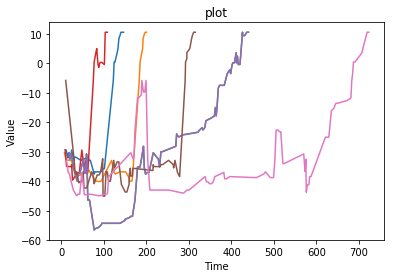

In [39]:
# plotting trajectiories fo students time vs. value of their current programs
SAMPLE_NUM = 7

for session in np.random.choice(df.loc[df['solved']]['task_session'], SAMPLE_NUM):
# list(df.loc[df['task_session'] == sessions[0]]['program', 'time'])
    programs = list(df.loc[df['task_session'] == session]['program'])
    times = list(df.loc[df['task_session'] == session]['time_from_start'])
    values = list(map(lambda x: V[x], programs))
    plt.plot(times, values)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('plot')
plt.show()

In [16]:
def create_dot_graph(filename, template, nx_graph, V, min_reward, max_reward, min_edge_prob, start='start'):
    start_value = V[start]
    V = {key: value - start_value for key, value in V.items()}
    dot_source = ''
    for node in nx_graph.nodes:
        value = V[node]
        value = max(min_reward, min(value, max_reward))
        green_val = int((value - min_reward) / (max_reward - min_reward) * 255)
        red_val = 255 - green_val
        red = hex(red_val)[2:]
        green = hex(green_val)[2:]
        color = red + green + '00'
        if node == start:
            color = '0000ff'
        if node in correct_states:
            color = 'ff00ff'
        dot_source += str(node).replace('=', '_EQ_').replace('>', '_GT_').replace('<', '_LT_').replace('/', 'O') \
                   + ' [label="", shape = square, fillcolor="#' + color + '"]\n'
        
    edge_source = ''
    for node in nx_graph.nodes:
        for next_node, values in nx_graph[node].items():
            if values['prob'] > min_edge_prob:
                edge_source += str(node).replace('=', '_EQ_').replace('>', '_GT_').replace('<', '_LT_').replace('/', 'O') + ' -> ' + \
                                str(next_node).replace('=', '_EQ_').replace('>', '_GT_').replace('<', '_LT_').replace('/', 'O') + '\n'
                
    f = open(template, 'r')
    prefix = f.read()
    f.close()
#     print(prefix)
    f = open(filename, 'w')
    suffix = dot_source
    suffix += edge_source
    suffix = suffix.replace('{', 'L')
    suffix = suffix.replace('}', 'R')
    suffix = suffix.replace('!', 'N')
    suffix += '}'
    f.write(prefix + suffix)
    f.close()
    
def create_dot_cluster_graph(filename, template, nx_graph, V, min_reward, max_reward):
    pass

In [16]:
create_dot_graph('task_' + str(level_id) + '_new.dot', 'template.dot', nx_graph, V, -30, 20, 0.2)

In [17]:
# HINTS

state = 'sR2{}'
best_next_val = -100
best_next_state = ''
next_states = sorted([(key, V[key]) for key, val in nx_graph.to_undirected()[state].items() 
                      if abs(ast.simple_distance(ast_trees.get(key, ast.program_to_tree(key)), ast_trees.get(state, ast.program_to_tree(state)))) < 10],
                         key=lambda x: x[1], reverse=True)
# for key, val in nx_graph.to_undirected()[state].items():
#     print(key, V[key])
next_states

[('sR2{r}', -3.72541731045642),
 ('sR2{}r', -8.019409199261673),
 ('sR2{f}', -11.005997741722258),
 ('s', -12.193170177095595)]

In [18]:
V['s']

-12.193170177095595

In [40]:
# removes unprobable edges
keep_prob = 0.05
for edge in list(nx_graph.edges):
    prob = nx_graph[edge[0]][edge[1]]['prob']
    if prob < keep_prob:
        nx_graph.remove_edge(edge[0], edge[1])
        
add_probability(nx_graph)

In [44]:
nx_graph['start']

AtlasView({'r': {'weight': 84, 'reward': -1, 'distance': 1, 'prob': 0.42857142857142855}, 'f': {'weight': 56, 'reward': -1, 'distance': 1, 'prob': 0.2857142857142857}, 'l': {'weight': 45, 'reward': -1, 'distance': 1, 'prob': 0.22959183673469388}, 's': {'weight': 11, 'reward': -1, 'distance': 1, 'prob': 0.05612244897959184}})

In [45]:
# clustering based on communities in graph and Gervin-Newman algorithm

from networkx.algorithms import community


communities_generator = community.girvan_newman(nx_graph)
communities = []
com_number = 10
for i in range(com_number):
    communities.append(next(communities_generator))

In [ ]:
len(communities[com_number - 1])

In [26]:
communities[10]

({'R10{s}',
  'R10{}',
  'R2{rfr}',
  'R2{s}',
  'R2{s}R2{r}',
  'R2{s}R2{r}R3{}',
  'R2{}',
  'R2{}R2{}',
  'R2{}f',
  'R2{}fR2{r}',
  'R2{}fr',
  'R2{}frl',
  'R2{}frr',
  'R2{}r',
  'R3{}',
  'R3{}R2{}',
  'R4{}fr',
  'fR2{rr}f',
  'ff',
  'fff',
  'frs',
  'r',
  'rr',
  'rrr',
  'rrrR2{}',
  'start'},
 {'R2{fr}R2{}',
  'R2{l}',
  'R4{fr}',
  'R4{f}',
  'R4{}',
  'f',
  'fR2{r}R2{s}',
  'fR2{r}lff',
  'fR2{}f',
  'fR3{}f',
  'ffr',
  'fr',
  'frR2{f}',
  'frR2{r}',
  'frR2{}',
  'frR2{}f',
  'frR2{}r',
  'frR3{f}',
  'frR3{r}',
  'frR3{}',
  'frR3{}f',
  'frR3{}r',
  'frR4{f}',
  'frR4{r}',
  'frR4{}',
  'frR5{f}',
  'frR6{f}',
  'frf',
  'frfR2{}',
  'frfR3{}',
  'frff',
  'frfff',
  'frrR4{f}',
  'frrR4{}',
  'frrr',
  'fs',
  'fsf',
  'fsfR2{}',
  'fsr',
  'fsrr',
  'l',
  'rrR2{f}',
  's',
  'sff',
  'sl',
  'ss'},
 {'ffrR2{}',
  'frl',
  'frlR2{}',
  'frlff',
  'frr',
  'frrR10{}',
  'frrR2{fff}',
  'frrR2{f}',
  'frrR2{}',
  'frrR2{}f',
  'frrR3{f}',
  'frrR3{}',
  'frrf',
  

In [23]:
# CREATE CLUSTER GRAPH
import copy
clusters = copy.deepcopy(list(communities[com_number - 1]))
correct_clusters = set()
# remove 'start'
for c in list(clusters):
    if 'start' in c:
        start_cluster = set()
        start_cluster.add('start')
        clusters.append(start_cluster)
        c.remove('start')
        break
# remove 'correct states'
for c in list(clusters):
    intersect = c.intersection(correct_states)
    for correct_prog in intersect:
        c.remove(correct_prog)
        correct_cluster = set()
        correct_clusters.add(correct_prog)
        correct_cluster.add(correct_prog)
        clusters.append(correct_cluster)
        
# node -> id of cluster
node_to_cluster = {}
for i in range(len(clusters)):
    c = clusters[i]
#     print(i)
    for node in c:
        node_to_cluster[node] = i
        
cluster_count = len(clusters)
print('Cluster count:', cluster_count)

cluster_graph = {}

for edge in nx_graph.edges:
    from_node = edge[0]
    to_node = edge[1]
    from_cluster = node_to_cluster[from_node]
    to_cluster = node_to_cluster[to_node]
    if from_cluster != to_cluster:
        cluster_graph[(from_cluster, to_cluster)] = cluster_graph.get((from_cluster, to_cluster), 0) + 1

nx_cl_G = nx.DiGraph()
nx_cl_G.add_nodes_from(range(cluster_count))

for key, value in cluster_graph.items():
    from_cluster = key[0]
    to_cluster = key[1]
    nx_cl_G.add_edge(from_cluster, to_cluster, weight=value, reward=-1)
    
add_probability(nx_cl_G)

Cluster count: 39


In [24]:
corret_clusters = set(map(lambda x: node_to_cluster[x], correct_clusters))
corret_clusters

{33, 34, 35, 36, 37, 38}

In [25]:
V_high = get_value(nx_cl_G, corret_clusters, 10)
V_high

Value iterations needed for convergence: 58


{0: -1.011239811597897,
 1: -3.6063526949305267,
 2: -4.622638335147255,
 3: -4.166029787777312,
 4: 1.4780130967093479,
 5: -2.643538444123129,
 6: -1.5048385892771616,
 7: -2.495471921876352,
 8: 1.187499498765002,
 9: -3.954167502058331,
 10: -2.8525054629735473,
 11: -3.5558480621875486,
 12: 6.96410378625242,
 13: -2.9478766263865657,
 14: -5.274193196011676,
 15: 2.2630045200835047,
 16: 2.1777567966289118,
 17: -0.5311676795103664,
 18: 8.9,
 19: 7.397290536905738,
 20: -3.2849909598329914,
 21: 1.9814706094686219,
 22: -2.4444457323153785,
 23: -2.643004727113926,
 24: -1.5591285478202275,
 25: 8.9,
 26: -4.904832323370066,
 27: -2.8568270311595736,
 28: -3.783397051123563,
 29: -2.8568270311595736,
 30: -2.052892139008195,
 31: -10,
 32: -3.2849909598329914,
 33: 10,
 34: 10,
 35: 10,
 36: 10,
 37: 10,
 38: 10}

In [26]:
create_dot_graph('clusters_' + str(level_id) + '_30cl.dot', 'template.dot', nx_cl_G, V_high, -10, 10, 0.01, node_to_cluster['start'])

In [27]:
# HIGH LEVEL HINTS
def get_high_level_hint(state, nx_cl_G, V_high, node_to_cluster):
    state = 'start'
    best_next_val = -100
    best_next_state = '' 
    try:
        state_cluster = node_to_cluster[state]
    except:
        return []
    next_states = sorted([(key, V_high[key], val['weight']) for key, val in nx_cl_G.to_undirected()[state_cluster].items() ],
                             key=lambda x: x[1], reverse=True)
    return next_states

In [28]:
get_high_level_hint('start', nx_cl_G, V_high, node_to_cluster)

[(0, -1.011239811597897, 1), (1, -3.6063526949305267, 1)]

In [29]:
import random

def get_color():
    r = hex(random.randint(0, 255))[2:]
    g = hex(random.randint(0, 255))[2:]
    b = hex(random.randint(0, 255))[2:]
    return r + g + b


def create_dot_graph_clusters(filename, template, nx_graph, node_to_cluster, min_reward, max_reward, min_edge_prob):
    cluster_to_color = {0: 'ff0000', 1: '00ff00', 2: '00000ff', 3: '00ffff', 4: 'ff00ff', 
                       5: 'ffff00', 6: '7d7d7d', 7: '7dff7d', 8: 'ff7d7d', 9: '7d007d',
                       10: '007d7d', 11: '7d7d00'}
    dot_source = ''
    for node in nx_graph.nodes:
        if node == 'start':
            color = 'ffc0cb'
        elif node in correct_states:
            color = '000000'
        else:
            color = cluster_to_color.get(node_to_cluster[node], get_color())
        dot_source += node.replace('=', '_EQ_').replace('>', '_GT_').replace('<', '_LT_').replace('/', 'O') \
                   + ' [label="", shape = square, fillcolor="#' + str(color) + '"]\n'
        
    edge_source = ''
    for node in nx_graph.nodes:
        for next_node, values in nx_graph[node].items():
            if values['prob'] > min_edge_prob:
                edge_source += node.replace('=', '_EQ_').replace('>', '_GT_').replace('<', '_LT_').replace('/', 'O') + ' -> ' + \
                                next_node.replace('=', '_EQ_').replace('>', '_GT_').replace('<', '_LT_').replace('/', 'O') + '\n'
                
    f = open(template, 'r')
    prefix = f.read()
    f.close()
    f = open(filename, 'w')
    suffix = dot_source
    suffix += edge_source
    suffix = suffix.replace('{', 'L')
    suffix = suffix.replace('}', 'R')
    suffix = suffix.replace('!', 'N')
    suffix += '}'
    f.write(prefix + suffix)
    f.close()
    
create_dot_graph_clusters('task_' + str(level_id) + '_cluster_graph.dot', 'template.dot', nx_graph, node_to_cluster, -20, 20, 0.1)

In [30]:
one_session = sessions[20]
sess_progs = list(df.loc[df['task_session'] == one_session]['program'])

In [31]:
import matplotlib.pyplot as plt

def unzip(alist):
    if alist == []:
        return ()
    length = len(alist[0])
    unziped = []
    for i in range(length):
        unziped.append([])
    for item in alist:
        for i in range(length):
            unziped[i].append(item[i])
    return tuple(unziped)

def get_difference(alist):
    diff = [0]
    for i in range(len(alist) - 1):
        diff.append(alist[i + 1] - alist[i])
    return diff


In [32]:
# average values for cluster movements for all sessions

to_plot = []
to_plot_un = []
for sess in sessions:
    sess_progs = list(df.loc[df['task_session'] == sess]['program'])
    length = len(sess_progs)
    time = df.loc[df['task_session'] == sess]['time_spent'].iloc[0]
    solved = df.loc[df['task_session'] == sess]['solved'].iloc[0]
    
    prog_val_list = []
    last_prog = ''
    last_cluster = -1
    for prog in sess_progs:
        # with clusters
#         cluster = node_to_cluster[prog]
#         if last_cluster == cluster:
#             continue
# #         print(prog)
#         prog_val_list.append((cluster, V_high[cluster]))
#         last_prog = prog
#         last_cluster = cluster
        # no cluster
        prog_val_list.append((prog, V[prog]))
    avg_val = sum([val for prog, val in prog_val_list]) / len(prog_val_list)
    if solved:
        to_plot.append((time, avg_val, sess, length))
    else:
        to_plot_un.append((time, avg_val, sess, length))
        

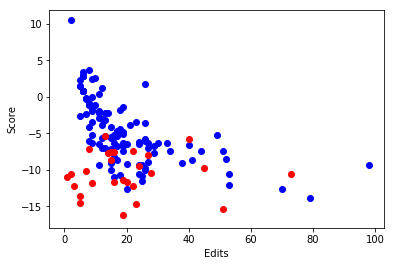

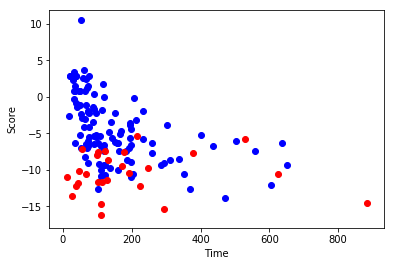

In [34]:
def create_plot(task_number, cluster_number, to_plot_solved, to_plot_unsolved, max_time=1000):
    to_plot_t = [x for x in to_plot if x[0] < max_time]
    to_plot_un = [x for x in to_plot_unsolved if x[0] < max_time]
    x, y, z, w = unzip(to_plot_t)
    plt.scatter(w, y, c='blue')
    plt.xlabel('Edits')
    plt.ylabel('Score')
    x, y, z, w = unzip(to_plot_un)
    plt.scatter(w, y, c='red')
    plt.savefig('task_' + str(task_number) + '_scatter_' + str(cluster_number) + 'cl_edits.png')
    plt.show()
    x, y, z, w = unzip(to_plot_t)
    plt.scatter(x, y, c='blue')
    plt.xlabel('Time')
    plt.ylabel('Score')
    x, y, z, w = unzip(to_plot_un)
    plt.scatter(x, y, c='red')
    plt.savefig('task_' + str(task_number) + '_scatter_' + str(cluster_number) + 'cl_time.png')
    plt.show()
    
create_plot(57, 30, to_plot, to_plot_un)

In [35]:
# sorts users by their Value on this task
sorted(to_plot,key=lambda x: x[1])

[(472, -13.833804212238995, 3964, 79),
 (102, -12.662602658046547, 3564, 20),
 (369, -12.571136956555568, 1047, 70),
 (606, -12.031074807965847, 1108, 53),
 (107, -11.55529611502345, 5592, 25),
 (197, -10.895101553712754, 6830, 16),
 (110, -10.869456204910534, 3536, 25),
 (121, -10.718313311288064, 2822, 18),
 (351, -10.575133660043706, 3257, 53),
 (204, -10.561514438942552, 239, 24),
 (161, -10.042226566997495, 2104, 26),
 (110, -9.992123022306693, 6151, 15),
 (138, -9.751803754612563, 399, 26),
 (118, -9.381574367535935, 8175, 11),
 (651, -9.33598721020265, 7288, 98),
 (284, -9.287365820614625, 368, 24),
 (122, -9.260624156376176, 5038, 25),
 (105, -9.116734124917885, 3879, 20),
 (72, -9.020262388714405, 7520, 15),
 (293, -9.011921957444919, 339, 38),
 (198, -8.885701233065992, 1184, 27),
 (187, -8.664762647810097, 343, 17),
 (311, -8.616699980939918, 336, 41),
 (337, -8.477403518194807, 6140, 52),
 (64, -8.163965580608684, 1549, 16),
 (260, -7.665346651401823, 1121, 29),
 (184, -7.4

In [36]:
df.loc[df['task_session'] == 3964]

id_x  task_session                       time   program granularity  \
52911  50710          3964 2018-01-25 08:30:51.938575      R2{}        edit   
52912  50723          3964 2018-01-25 08:30:52.843733      R2{}   execution   
52914  50802          3964 2018-01-25 08:31:02.493272         f        edit   
52915  50816          3964 2018-01-25 08:31:04.466792        fr        edit   
52916  50835          3964 2018-01-25 08:31:06.295413        fr   execution   
52917  50938          3964 2018-01-25 08:31:17.588126         f        edit   
52918  51074          3964 2018-01-25 08:31:33.726727        fr        edit   
52919  51152          3964 2018-01-25 08:31:44.356302       frf        edit   
52920  51169          3964 2018-01-25 08:31:46.754141       frf   execution   
52921  51204          3964 2018-01-25 08:31:52.821308      frff        edit   
52922  51230          3964 2018-01-25 08:31:53.733258      frff   execution   
52923  51300          3964 2018-01-25 08:32:02.861722        fr        edit   
52924  51307          3964 2018-01-25 08:32:03.412754      frff        edit   
52925  51326          3964 2018-01-25 08:32:05.624680         f        edit   
52927  51445          3964 2018-01-25 08:32:17.645842     frfff        edit   
52929  51562          3964 2018-01-25 08:32:28.026351         s        edit   
52930  51587          3964 2018-01-25 08:32:31.182764         s   execution   
52932  51635          3964 2018-01-25 08:32:36.860514         f        edit   
52933  51696          3964 2018-01-25 08:32:44.571969        fr        edit   
52934  51707          3964 2018-01-25 08:32:46.412874    frR2{}        edit   
52935  51734          3964 2018-01-25 08:32:48.713756    frR2{}   execution   
52936  51757          3964 2018-01-25 08:32:51.847691        fr        edit   
52937  51838          3964 2018-01-25 08:33:02.269151       frf        edit   
52938  51888          3964 2018-01-25 08:33:08.157868       frf   execution   
52940  52072          3964 2018-01-25 08:33:34.642871         f        edit   
52941  52127          3964 2018-01-25 08:33:44.414524        fr        edit   
52942  52146          3964 2018-01-25 08:33:48.111168       frf        edit   
52943  52150          3964 2018-01-25 08:33:49.414056   frfR2{}        edit   
52944  52159          3964 2018-01-25 08:33:52.022082   frfR2{}   execution   
52945  52207          3964 2018-01-25 08:34:00.475961       frf        edit   
...      ...           ...                        ...       ...         ...   
52965  52657          3964 2018-01-25 08:35:14.533256       frr        edit   
52967  52667          3964 2018-01-25 08:35:16.432937       frr        edit   
52968  52684          3964 2018-01-25 08:35:19.189698       frr   execution   
52969  52731          3964 2018-01-25 08:35:29.202114   frrR3{}        edit   
52971  52774          3964 2018-01-25 08:35:36.639419      R3{}        edit   
52972  52798          3964 2018-01-25 08:35:39.704182  R3{}R2{}        edit   
52973  52809          3964 2018-01-25 08:35:41.575818  R3{}R2{}   execution   
52974  52830          3964 2018-01-25 08:35:44.961915  R2{}R2{}        edit   
52977  52954          3964 2018-01-25 08:36:02.083498       frr        edit   
52978  53051          3964 2018-01-25 08:36:14.855989   frrR2{}        edit   
52979  53108          3964 2018-01-25 08:36:23.615468   frrR2{}   execution   
52980  53159          3964 2018-01-25 08:36:31.416832   frrR2{}   execution   
52981  53181          3964 2018-01-25 08:36:35.736130  frrR10{}        edit   
52982  53195          3964 2018-01-25 08:36:38.207601  frrR10{}   execution   
52983  53208          3964 2018-01-25 08:36:40.213860       frr        edit   
52985  53349          3964 2018-01-25 08:37:06.091834       frr        edit   
52986  53368          3964 2018-01-25 08:37:08.886439       frr   execution   
52987  53461          3964 2018-01-25 08:37:22.104171        fr        edit   
52988  53471          3964 2018-01-25 08:37:23.540386    f

In [143]:
correct_states

{'R2{f}R4{rf}f',
 'R2{f}R4{rf}l',
 'R2{s}R4{rf}f',
 'fR4{fr}R2{f}',
 'fR4{fr}ff',
 'fR4{fr}fl',
 'fR4{fr}fs',
 'fR4{fr}ss',
 'ffR4{rf}f',
 'sR4{sr}R2{s}',
 'sR4{sr}ss'}